In [426]:
# notes
# - early large takers seem to have sold by now (maybe influencers, or bots, or greedier insiders?)
# - misses transactions in other pools -- might explain jaredfromsubway being negative here?

# TODO:
# - check for timing of trades -- were big sells consistently followed by big buys of the same address?


In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import time
import requests
import json
from web3 import Web3
from web3 import _utils # for error handling
from multiprocessing.pool import Pool,ThreadPool
import os
from os import listdir
from os.path import isfile, join


# flipside crypto sdk
from shroomdk import ShroomDK


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# for parallel processing, which speeds many api calls that need to run one at a time
# from multiprocessing import Pool # issue with imports
import multiprocess as mp # fork of above library that works for non-imported functions


# create the plot using seaborn

# load environment variables like keys
from dotenv import load_dotenv
load_dotenv()

# saving dictionaries and pd dataFrames
import pickle
def save_obj(obj, name):
    with open(name+'.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name+'.pkl', 'rb') as f:
        return pickle.load(f)

In [2]:
# alchemy api key from https://dashboard.alchemy.com/
apiKey=os.getenv('ALCHEMY_KEY')
base_url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{apiKey}"

In [3]:
# flipside api key from; https://sdk.flipsidecrypto.xyz/shroomdk/apikeys
flipside_key = os.getenv('FLIPSIDE_KEY')
flipside_sdk = ShroomDK(flipside_key)

In [207]:
# flipside query method docs; https://docs.flipsidecrypto.com/shroomdk-sdk/get-started/python
# 1M rows max per query
# 100k results max per page
# query results are cached, fetching pages doesn't count toward query rate limits

# pagination function adapted from; https://docs.flipsidecrypto.com/shroomdk-sdk/examples
def querying_pagination(query_string):
    # Query results page by page and saves the results in a list
    # If nothing is returned then just stop the loop and start adding the data to the dataframe
    result_list = []
    for i in range(1,11): # max is a million rows @ 100k per page
        print(f'running page {i}')
        data=flipside_sdk.query(query_string,page_size=100000,page_number=i,ttl_minutes=int(60*24),timeout_minutes=60)
        if data.run_stats.record_count == 0:  
            break
        else:
            result_list.append(data.records)
        
    # Loops through the returned results and adds into a pandas dataframe
    result_df=pd.DataFrame()
    for idx, each_list in enumerate(result_list):
        if idx == 0:
            result_df=pd.json_normalize(each_list)
        else:
            result_df=pd.concat([result_df, pd.json_normalize(each_list)])

    return result_df

# Setup

## Connect to ethereum node, instantiate contract objects

In [5]:
# connect to an ethereum node
alchemy_url = f"https://eth-mainnet.g.alchemy.com/v2/{apiKey}"
w3 = Web3(Web3.HTTPProvider(alchemy_url))
print(w3.isConnected())

True


In [6]:
weth_address = Web3.toChecksumAddress("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")

# contracts, abis from etherscan
address_wagdie_nft = Web3.toChecksumAddress("0x659a4bdaaacc62d2bd9cb18225d9c89b5b697a5a")
abi_wagdie_nft = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[],"name":"ApprovalCallerNotOwnerNorApproved","type":"error"},{"inputs":[],"name":"ApprovalQueryForNonexistentToken","type":"error"},{"inputs":[],"name":"ApprovalToCurrentOwner","type":"error"},{"inputs":[],"name":"ApproveToCaller","type":"error"},{"inputs":[],"name":"BalanceQueryForZeroAddress","type":"error"},{"inputs":[],"name":"MintToZeroAddress","type":"error"},{"inputs":[],"name":"MintZeroQuantity","type":"error"},{"inputs":[],"name":"OwnerQueryForNonexistentToken","type":"error"},{"inputs":[],"name":"TransferCallerNotOwnerNorApproved","type":"error"},{"inputs":[],"name":"TransferFromIncorrectOwner","type":"error"},{"inputs":[],"name":"TransferToNonERC721ReceiverImplementer","type":"error"},{"inputs":[],"name":"TransferToZeroAddress","type":"error"},{"inputs":[],"name":"URIQueryForNonexistentToken","type":"error"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"approved","type":"address"},{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"operator","type":"address"},{"indexed":false,"internalType":"bool","name":"approved","type":"bool"}],"name":"ApprovalForAll","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"previousOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":true,"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"Transfer","type":"event"},{"inputs":[],"name":"MAX_MINT","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"MAX_SUPPLY","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"TEAM_CLAIM_AMOUNT","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"addressClaimed","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"approve","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"claimed","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bool","name":"mintStarted","type":"bool"}],"name":"enableMint","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"getApproved","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"operator","type":"address"}],"name":"isApprovedForAll","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"mint","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"ownerOf","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"renounceOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"safeTransferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"},{"internalType":"bytes","name":"_data","type":"bytes"}],"name":"safeTransferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"operator","type":"address"},{"internalType":"bool","name":"approved","type":"bool"}],"name":"setApprovalForAll","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"string","name":"baseURI_","type":"string"}],"name":"setBaseURI","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"started","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes4","name":"interfaceId","type":"bytes4"}],"name":"supportsInterface","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"teamClaim","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"tokenURI","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"tokenId","type":"uint256"}],"name":"transferFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"}]'

address_wagdie_token = Web3.toChecksumAddress("0x6d627C33eeA1a1b4b139C0B788010fF50B80B513")
# abi_wagdie_token = ''
# token abi hasnt been decoded, NFTX admin recommended using the proxy contract: https://etherscan.io/address/0x36b799160cdc2d9809d108224d1967cc9b7d321c#code

address_ded_token = Web3.toChecksumAddress("0xdbbe358fead311b4089b8bf30f455c041e67f5f4")
abi_ded_token = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"previousOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"inputs":[],"name":"DOMAIN_SEPARATOR","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"INITIAL_SUPPLY","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"adminWallet","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"burn","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"account","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"burnFrom","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"claim","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"address","name":"recipient","type":"address"}],"name":"claimTo","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"subtractedValue","type":"uint256"}],"name":"decreaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"addedValue","type":"uint256"}],"name":"increaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"nonces","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"permit","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"renounceOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_adminWallet","type":"address"}],"name":"setAdminWallet","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"}]'

pair_eth_ded = Web3.toChecksumAddress("0x4e4cc558ff956c7f500c4ada573fa97e63281153")
abi_pair_eth_ded = '[{"inputs":[],"payable":false,"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"},{"indexed":true,"internalType":"address","name":"to","type":"address"}],"name":"Burn","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Mint","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount0In","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1In","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount0Out","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1Out","type":"uint256"},{"indexed":true,"internalType":"address","name":"to","type":"address"}],"name":"Swap","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint112","name":"reserve0","type":"uint112"},{"indexed":false,"internalType":"uint112","name":"reserve1","type":"uint112"}],"name":"Sync","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"constant":true,"inputs":[],"name":"DOMAIN_SEPARATOR","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"MINIMUM_LIQUIDITY","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"PERMIT_TYPEHASH","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"internalType":"address","name":"","type":"address"},{"internalType":"address","name":"","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"to","type":"address"}],"name":"burn","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"getReserves","outputs":[{"internalType":"uint112","name":"_reserve0","type":"uint112"},{"internalType":"uint112","name":"_reserve1","type":"uint112"},{"internalType":"uint32","name":"_blockTimestampLast","type":"uint32"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"_token0","type":"address"},{"internalType":"address","name":"_token1","type":"address"}],"name":"initialize","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"kLast","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"to","type":"address"}],"name":"mint","outputs":[{"internalType":"uint256","name":"liquidity","type":"uint256"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"nonces","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"permit","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"price0CumulativeLast","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"price1CumulativeLast","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"to","type":"address"}],"name":"skim","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"uint256","name":"amount0Out","type":"uint256"},{"internalType":"uint256","name":"amount1Out","type":"uint256"},{"internalType":"address","name":"to","type":"address"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"swap","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[],"name":"sync","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"token0","outputs":[{"internalType":"address","name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"token1","outputs":[{"internalType":"address","name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"}]'

# token_pair = "0x4e4cc558ff956c7f500c4ada573fa97e63281153" # DED/ETH

# # ded team;
# episom3 - bayc#4527
# pascale.eth - cryptopunk#7465
# takethedeal.eth - cryptopunk#1232
# facedown.eth - cryptopunk#3764
# brennen.eth - cryptopunk #7360
# 0xredpunk.eth - cryptopunk #7674
# 0x0wl - inscribed pepes #69

In [7]:
# instantiate contracts
contract_wagdie_nft = w3.eth.contract(address = address_wagdie_nft, abi = abi_wagdie_nft)
# contract_wagdie_token = w3.eth.contract(address = address_wagdie_token, abi = abi_wagdie_token)
contract_ded_token = w3.eth.contract(address = address_ded_token, abi = abi_ded_token)
contract_eth_ded = w3.eth.contract(address = pair_eth_ded, abi = abi_pair_eth_ded)

# Helper Functions

# The Graph helper functions

# THESE DON'T INCLUDE MY SELLS!!!

* work for buys
* for sells, 'to' and 'sender' are both uniswap router, but there is still a transaction id
* TODO: use transaction id and parse transactions to get swaps...

In [14]:
def get_all_swaps_for_pair(pair_address = "0x4e4cc558ff956c7f500c4ada573fa97e63281153",t0=0):
    swaps = []
    first = 1000
    attempt = 0
    while True:
        query = """
        {
          swaps(where: { pair: "%s", timestamp_gte: "%i" }, orderBy: timestamp, orderDirection: asc, first: %d) {
            id
            timestamp
            pair {
              token0 {
                symbol
              }
              token1 {
                id
                symbol
              }
            }
            amount0In
            amount0Out
            amount1In
            amount1Out
            amountUSD
            timestamp
            to
            sender
            transaction {
              id
            }
          }
        }
        """ % (pair_address, t0, first)
        
        response = requests.post("https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2", json={'query': query})
        data = response.json().get('data', {})
        if not data:
            # Retry if response is empty or invalid
            attempt+=1
            print(f"attempt: {attempt}, response: {response.status_code}. Retrying in 1 second...")
            print(response.json())
            time.sleep(2)
            continue
        attempt=0
        # update t0
        # TODO: add check that not all timestamps are the same, if so need larger 'first'?
        swaps.extend(data['swaps'])
        if len(data['swaps']) < first:
            break
        # if not done, update t0
        t0 = int(response.json().get('data', {})['swaps'][-1]['timestamp'])
        # skip += first

    df = pd.DataFrame(swaps)
    df['pair'] = df['pair'].apply(lambda x: f"{x['token0']['symbol']}/{x['token1']['symbol']}")
    df['amount0In'] = pd.to_numeric(df['amount0In'])
    df['amount0Out'] = pd.to_numeric(df['amount0Out'])
    df['amount1In'] = pd.to_numeric(df['amount1In'])
    df['amount1Out'] = pd.to_numeric(df['amount1Out'])
    df['amountUSD'] = pd.to_numeric(df['amountUSD'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    return df

In [15]:
df_swaps = get_all_swaps_for_pair(pair_address = "0x4e4cc558ff956c7f500c4ada573fa97e63281153",t0=0)

In [16]:
df_swaps['p_usd'] = df_swaps['amountUSD'] / (df_swaps['amount1In']+df_swaps['amount1Out'])
df_swaps['side'] = np.where(df_swaps['amount1In'] == 0, 'buyer', 'seller')
df_swaps['flow'] = df_swaps.apply(lambda x: x.amountUSD * (-1)**(1 if x.side=='buyer' else 0) ,axis=1)
df_swaps['tx_id'] = df_swaps.apply(lambda x: x['transaction']['id'],axis=1)

In [18]:
# get transaction 'from' addresses
def get_tx_from(tx_id):
    tx = w3.eth.getTransaction(tx_id)
    # print(block_number, block.timestamp)
    return tx_id, tx['from']

with mp.Pool(4) as pool:
    results = pool.map(get_tx_from, list(df_swaps['tx_id']))

In [19]:
# convert to df
tx_from_df = pd.DataFrame(results, columns=['tx_id', 'tx_from'])
# join to swaps df
df_swaps = pd.merge(df_swaps, tx_from_df, on='tx_id',how='left')


# TODO: verify maker would just be the from address?
# df_swaps['maker'] = df_swaps.apply(lambda x: x.to if x.side=='buyer' else x.sender,axis=1)

In [ ]:
# Addresses to copy trade?
## Check pnl by address thus far
df_swaps.groupby('tx_from')['flow'].sum().reset_index().sort_values('flow')

In [ ]:
## Check which are sitting on profits
# may not be informative given holders..

# for each address, 
# get cumulative flows
# get cumulative balances
# multiply balances by last USD value

In [84]:
# set tx_from as the dataframe index for easy grouping
tmp = df_swaps#.set_index('tx_from') #, inplace=True)

# define time window lengths
windows = [timedelta(minutes=10), timedelta(minutes=20), timedelta(minutes=30)]


In [72]:
# tmp.groupby(['tx_from','side', pd.Grouper(key='timestamp', freq=windows[2], offset=0)]).mean()['flow']
# tmp['avg_flow_in_window'] = tmp['flow'].shift(1).rolling('30min', min_periods=1, center=False).mean()

# DOESNT WORK RIGHTs

# tmp = tmp.set_index('timestamp')
tmp['avg_flow_in_window'] = tmp.set_index('timestamp').groupby(['tx_from', 'side'])['flow'].rolling('30T', freq='1T').mean().reset_index()['flow']

# def rolling_mean_excluding_current(row):
#     return row.iloc[1:].mean()

# tmp['avg_flow_in_window'] = tmp.set_index('timestamp').groupby(['tx_from', 'side'])['flow'].rolling('30T', freq='1T').apply(rolling_mean_excluding_current).reset_index(level=[0, 1], drop=True)
# tmp.rolling(key='timestamp','30T', freq='1T').apply(rolling_mean_excluding_current) #.reset_index(level=[0, 1], drop=True)

In [87]:
# tmp['flow']

0      -1004.218958
1      -9621.001827
2       -195.544378
3       -195.538204
4        -97.573603
           ...     
8609   -1138.385596
8610       0.656395
8611      13.658530
8612     -12.527600
8613    1678.092125
Name: flow, Length: 8614, dtype: float64

In [104]:
tmp.tail(50)

,id,timestamp,pair,amount0In,amount0Out,amount1In,amount1Out,amountUSD,to,sender,transaction,p_usd,side,flow,tx_id,tx_from,avg_flow_in_window,total_flow_in_window
8564,0xdb9119b951caddba5a6bf2110dfcafd8a45f7b73a634...,2023-04-27 16:25:59,WETH/DED,0.000000,0.212046,5.930742e+08,0.000000e+00,401.916237,0x208522a06e4420092df8cb05a6823e6c5b81882f,0x208522a06e4420092df8cb05a6823e6c5b81882f,{'id': '0xdb9119b951caddba5a6bf2110dfcafd8a45f...,6.776829e-07,seller,401.916237,0xdb9119b951caddba5a6bf2110dfcafd8a45f7b73a634...,0xC469799A23Ce2eDE323F6214bfAAcC49df942f62,337.218270,14086.796687
8565,0x36fc6a9f5ee99bb14aae35d42832a1b45fb5aa36622a...,2023-04-27 16:36:35,WETH/DED,0.094275,0.000000,0.000000e+00,2.627376e+08,178.724150,0xfa57a125666bdc27a31a31c4e6c1fb615d45fb04,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,{'id': '0x36fc6a9f5ee99bb14aae35d42832a1b45fb5...,6.802382e-07,buyer,-178.724150,0x36fc6a9f5ee99bb14aae35d42832a1b45fb5aa36622a...,0xFA57a125666bDC27a31a31c4e6c1FB615D45fb04,1338.105345,11939.112608
8566,0xa3c566aa1f3391071b3c43ea97dfb526b35379f2ba82...,2023-04-27 16:51:23,WETH/DED,0.160000,0.000000,0.000000e+00,4.435953e+08,303.388235,0xfe6762ddfb0c35b5ebb197a448f09dfb06ec94fa,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,{'id': '0xa3c566aa1f3391071b3c43ea97dfb526b353...,6.839302e-07,buyer,-303.388235,0xa3c566aa1f3391071b3c43ea97dfb526b35379f2ba82...,0xfe6762ddfb0C35b5Ebb197a448F09dfb06EC94fa,-118.888941,-80.196148
8567,0x4dc88cc7f3ba17a2dcf28d25b010674db0c9ef948da4...,2023-04-27 17:00:11,WETH/DED,0.000000,0.494601,1.339726e+09,0.000000e+00,934.573514,0x6b75d8af000000e20b7a7ddf000ba900b4009a80,0x6b75d8af000000e20b7a7ddf000ba900b4009a80,{'id': '0x4dc88cc7f3ba17a2dcf28d25b010674db0c9...,6.975856e-07,seller,934.573514,0x4dc88cc7f3ba17a2dcf28d25b010674db0c9ef948da4...,0xae2Fc483527B8EF99EB5D9B44875F005ba1FaE13,275.732945,452.461130
8568,0x81271a74ee62de20f2d00672c0d9ba97696aa67a0dac...,2023-04-27 17:00:11,WETH/DED,0.400000,0.000000,0.000000e+00,1.074929e+09,760.389071,0x5fc62410ff9393bc8cc46a1f451c9965713235a7,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,{'id': '0x81271a74ee62de20f2d00672c0d9ba97696a...,7.073855e-07,buyer,-760.389071,0x81271a74ee62de20f2d00672c0d9ba97696aa67a0dac...,0x5fC62410FF9393Bc8cC46A1f451c9965713235a7,-194.730153,-307.927942
8569,0x973ff37c656fe67bb4c1c92face57dcb9aa16948f5fe...,2023-04-27 17:00:11,WETH/DED,0.489646,0.000000,0.000000e+00,1.339726e+09,931.689169,0x6b75d8af000000e20b7a7ddf000ba900b4009a80,0x6b75d8af000000e20b7a7ddf000ba900b4009a80,{'id': '0x973ff37c656fe67bb4c1c92face57dcb9aa1...,6.954326e-07,buyer,-931.689169,0x973ff37c656fe67bb4c1c92face57dcb9aa16948f5fe...,0xae2Fc483527B8EF99EB5D9B44875F005ba1FaE13,-146.029721,-1239.617111
8570,0x44fc0032093648a2d80f457040b3262157432c862367...,2023-04-27 17:23:11,WETH/DED,2.000000,0.000000,0.000000e+00,5.227792e+09,3878.427167,0xd4315668aa1d88b4c581ec6fa902e131286dd0ab,0xd4315668aa1d88b4c581ec6fa902e131286dd0ab,{'id': '0x44fc0032093648a2d80f457040b326215743...,7.418862e-07,buyer,-3878.427167,0x44fc0032093648a2d80f457040b3262157432c862367...,0x8095B77c87E3E983EEea94411325e371bB0Ce087,293.453749,-4635.931893
8571,0x0648cc8a18df6ce77b871237efad564ccabff593cdbf...,2023-04-27 17:30:11,WETH/DED,0.050000,0.000000,0.000000e+00,1.254807e+08,95.073404,0x62c0c9e29ad8eb3058cf00a8dad6317f92a4d52a,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,{'id': '0x0648cc8a18df6ce77b871237efad564ccabf...,7.576734e-07,buyer,-95.073404,0x0648cc8a18df6ce77b871237efad564ccabff593cdbf...,0x62c0C9E29Ad8Eb3058CF00a8DAd6317f92a4D52A,966.245914,-3973.500571
8572,0x5a3be78ed3613ef1824a2a1c84ec1f8543c879ff9ac3...,2023-04-27 17:40:35,WETH/DED,0.000000,0.252028,6.388199e+08,0.000000e+00,479.573724,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,{'id': '0x5a3be78ed3613ef1824a2a1c84ec1f8543c8...,7.507182e-07,seller,479.573724,0x5a3be78ed3613ef1824a2a1c84ec1f8543c879ff9ac3...,0xB13D16A8F2dBd0914a4eCF9A4Cb29f3747f99402,12.192185,-3493.926847
8573,0x7d17f11c3c47211a915fac223

In [155]:
# Issue, numbers aren't correct vs manually checking last few rows above!! 

# tmp.set_index('timestamp')['avg_flow_in_window'].plot()
# tmp.set_index('timestamp')['flow'].to_frame().rolling('30T', freq='1T').mean() #.reset_index()['flow']

# rolling_mean = 
# tmp['total_flow_in_window'] = tmp.set_index('timestamp')['flow'].shift(-90, freq='20s').rolling('30min', min_periods=1).sum().reset_index()['flow']


tmp['timestamp_shift_30m']=tmp.set_index('timestamp').shift(-1, freq='30min').reset_index()['timestamp']

# tmp.rolling('30min', min_periods=1, on='timestamp_shift_30m').sum().reset_index()['flow']


# Issue, numbers aren't correct: 
# even for different shifts above, the numbers from the window are the same 
# regardless od set_index() or of .rolling(on='..')..

# tmp.set_index()['flow'].rolling('30min', min_periods=1, on='timestamp').sum().reset_index()['flow']
tmp.set_index('timestamp').rolling('30min', min_periods=1)['flow'].sum().reset_index() #['flow']
tmp[['timestamp','timestamp_shift_30m']]

In [163]:
## identify insider addresses: 

# for each address's buys and sells, get;
## the price change over different time ranges, 
## inflows & outflows over those time ranges

# get stats like
## net flows after a buy - net flows after a sell
## 


In [ ]:
## 'non insider liq' signal

## define Tier 1 insiders?

## define Tier 2 insiders;
### bought 100,000 around the time brennen told us about that

## get cumulative USD flow by non insiders

In [20]:
## Figure to show price + indicators of when a wallet bought/sold

In [21]:
# save df for now..
# df_swaps.to_csv('swaps.csv')

In [22]:
df_swaps.loc[df_swaps['tx_id']=='0xa41a9f0b3f57417c5f824b823ebe8ab6b1010f2073228f5d841fda82f8345883']

,id,timestamp,pair,amount0In,amount0Out,amount1In,amount1Out,amountUSD,to,sender,transaction,p_usd,side,flow,tx_id,tx_from
8370,0xa41a9f0b3f57417c5f824b823ebe8ab6b1010f207322...,2023-04-26 11:48:47,WETH/DED,0.0,0.548108,1.163241e+09,0.0,1045.934209,0x6b75d8af000000e20b7a7ddf000ba900b4009a80,0x6b75d8af000000e20b7a7ddf000ba900b4009a80,{'id': '0xa41a9f0b3f57417c5f824b823ebe8ab6b101...,8.991553e-07,seller,1045.934209,0xa41a9f0b3f57417c5f824b823ebe8ab6b1010f207322...,0xae2Fc483527B8EF99EB5D9B44875F005ba1FaE13


In [23]:
# Some top 30 gainer addresses don't appear in etherscan...
# 0x1113eFd5C8896CcF251EA360bB9d91F113707F80 --> another address that may be a swapper
# 0xCFC42ffec0F9fB643A7E01A53E7e0bDfd90a66A6 --> 0xd4315668aa1d88b4c581ec6fa902e131286dd0ab (maybe a swapper contract?)
list(df_swaps.loc[df_swaps['tx_from']=='0x1113eFd5C8896CcF251EA360bB9d91F113707F80'].tx_id)

['0xe7736600ee209104a04c3f8d360db0d0c9308cf962fea7efd1f345ac5f7d90e9',
 '0xc589c6fc96a205f0579daceff78b26bba9d8560d63c5f6c4984bc1858359f9bd',
 '0x188432d19800ebac2a22a649bc520dad9148b07bbd9079167c301246ca52adea',
 '0x8f047673a72bba616d66fb3526083072adf77cf5ec8f354f429e93dd4f0079e4',
 '0x3bca7b7884d8dd92a8843a931346ae6ebe3eb3a3f4aee901fe9a5ed61478f562',
 '0xa787e604b127fd8ca1f1fae0605d083c4fc971c1276ed5c375eb52754a556723',
 '0x20536667669b4a9f24e360ee6247d167c249fc106e12168569b7ed47143acba3']

In [425]:

df_swaps.groupby(['side','tx_from'])['flow'].sum().reset_index().query("tx_from=='0xae2Fc483527B8EF99EB5D9B44875F005ba1FaE13'")

,side,tx_from,flow
1764,buyer,0xae2Fc483527B8EF99EB5D9B44875F005ba1FaE13,-2.471814e+06
3328,seller,0xae2Fc483527B8EF99EB5D9B44875F005ba1FaE13,2.346425e+06


In [25]:
( # get just 1 address
df_swaps.groupby('tx_from')['flow'].sum().reset_index().sort_values('flow')
).tail(30)

#( # get just 1 address
# df_swaps.groupby('tx_from')['flow'].sum().reset_index().sort_values('flow')
#    .query("tx_from=='0xcdfc8F3377bBf5c912D2b031b1691D91Fec9fF32'")
# )

,tx_from,flow
633,0x471bC2AFD40aE4fe0af9b282472d99ED5A0A8e39,3691.505086
594,0x43134dD29523c86c1AC6d0Ccb920278b2b89eac0,3701.314573
717,0x5121858F000bF715aa864fCa756bdA85f2AE8A55,3823.710545
1905,0xc47cA739c179E8A51fE2713dd038cD87261cADfB,3925.024881
201,0x1529282Ea2D39c1a7a78608c0D0cAB72A265196D,4039.596716
626,0x4688456aF09503898982552fFEE5A4d4cdf23126,4166.251990
1451,0xB61cbc559425BF5F156D8c759B4a72FF09a2DC30,4355.176270
1080,0x7cdf84E2515118A89CBD81C2E6Ad1d874aded3d0,4472.539856
2010,0xdc336C6f9E587F6EC725896a7b5C15f630B65e57,5234.526749
106,0x0D075d8bdEFee4Aecc9516d74b9bd95401B701fd,5264.471449


In [ ]:
# TODO: price points for people still holding
# TODO: use side to indicate taking sender or to address

In [399]:
df_swaps.groupby('tx_from').count().sort_values('id')

# 0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b # = uniswap router
# 0x6b75d8af000000e20b7a7ddf000ba900b4009a80 # jared from subway
# 0x7a250d5630b4cf539739df2c5dacb4c659f2488d # = deployer

,id,timestamp,pair,amount0In,amount0Out,amount1In,amount1Out,amountUSD,to,sender,transaction,p_usd,side,flow,tx_id
tx_from,,,,,,,,,,,,,,,
0xDe2998a0a3C3CB99179e774451e75f8492837088,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0x8b103A54a52597375A9A947dDC6967f414FF6C4d,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0x3A148C4d3F7D75C6eF7ec00a6d6CE3E43c0cb701,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0x3AD454d57ef52254552EdD88A44F1D1319852D77,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0x8FF2B874c127712e2762Df35b232F831f30fCf89,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x77BB4EF7Ba460C80a7D7bfD475dBB7c7fc82333b,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37
0xcdfc8F3377bBf5c912D2b031b1691D91Fec9fF32,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
0x77ad3a15b78101883AF36aD4A875e17c86AC65d1,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72


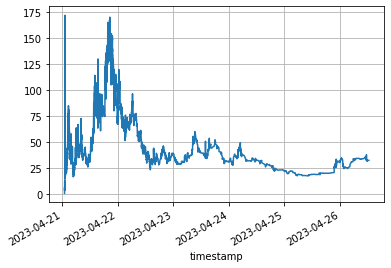

In [397]:
(df_swaps.set_index('timestamp').p_usd/df_swaps.p_usd[0]).plot()
# df.p_usd.plot()
plt.grid()

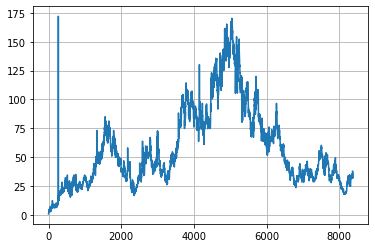

In [398]:
(df_swaps.p_usd/df_swaps.p_usd[0]).plot()
plt.grid()

In [ ]:
# # contract_eth_ded
# # get the transaction receipt using the transaction hash
# tx_hash = '0x642416365e3e657caf9923f67ddc34d9444f37a6c4e9ba02f341dbb5806a7de4'
# # 0x642416365e3e657caf9923f67ddc34d9444f37a6c4e9ba02f341dbb5806a7de4
# tx_receipt = w3.eth.getTransactionReceipt(tx_hash)
# tx_receipt['from']

In [307]:
# # get all transactions..
# # import web3

# # Connect to the Ethereum mainnet
# # w3 = web3.Web3(web3.Web3.HTTPProvider('https://mainnet.infura.io/v3/<your-project-id>'))

# # 0x642416365e3e657caf9923f67ddc34d9444f37a6c4e9ba02f341dbb5806a7de4 # a transaction where I sold
# # check on https://thegraph.com/hosted-service/subgraph/uniswap/uniswap-v2

# # List of transaction IDs for swaps
# tx_ids = [i for i in df.apply(lambda x: x.transaction['id'],axis=1).values]

# # Loop through the transaction IDs and get the corresponding transactions
# swap_txs = []
# for tx_id in tx_ids:
#     tx = w3.eth.getTransaction(tx_id)
#     # tx_receipt = w3.eth.getTransactionReceipt(tx_hash)
#     swap_txs.append(tx['from'])

# #     # contract_eth_ded
# # # get the transaction receipt using the transaction hash
# # tx_hash = '0x642416365e3e657caf9923f67ddc34d9444f37a6c4e9ba02f341dbb5806a7de4'
# # # 0x642416365e3e657caf9923f67ddc34d9444f37a6c4e9ba02f341dbb5806a7de4
# # tx_receipt = w3.eth.getTransactionReceipt(tx_hash)
# # tx_receipt['from']

# # Print the resulting list of transactions
# # print(swap_txs)


In [292]:
# # df.groupby('maker')['flow'].sum().reset_index().sort_values('flow')
# # s='0xcdfc8F3377bBf5c912D2b031b1691D91Fec9fF32'.lower()
# # df.groupby('maker')['flow'].sum().reset_index().sort_values('flow').head(30)

# df.loc[df.to == '0xcdfc8f3377bbf5c912d2b031b1691d91fec9ff32']#.transaction.values

## Web3 helper functions

### Load local block number --> datetime table

In [12]:
# try loading existing timestamp data
# as a function bc it is used later in code to fill missing blocks
def load_block_timestamps_df(filename = 'block_timestamps.csv'):
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        df = pd.DataFrame(columns=['timestamp'])
    return df
block_timestamps_df = load_block_timestamps_df()

In [13]:
block_timestamps_df.sort_values('blockNumber',inplace=True)
block_timestamps_df['datetime'] = pd.to_datetime(block_timestamps_df['timestamp'], unit='s')
# block_timestamps_df

### Get block --> datetime mappings, using flipside crypto

In [14]:
# # # use flipside crypto to get new timestamp data as needed
# # qry_str = f"""
# # SELECT BLOCK_NUMBER, BLOCK_TIMESTAMP
# # FROM ETHEREUM.core.sv_fact_blocks
# # ORDER BY BLOCK_NUMBER DESC
# # LIMIT 1000000 -- flipside limits to 1M
# # OFFSET 2000000
# # """
# # df = querying_pagination(qry_str)
# # process df
# dff=df.copy()
# # convert datetimes to timestamps
# dff['timestamp'] = pd.DatetimeIndex(dff.block_timestamp).asi8 // 10 ** 9
# dff.rename(columns={'block_number':'blockNumber'},inplace=True)
# dff.drop(columns=['block_timestamp'],inplace=True)
# dff.rename(columns={'block_number':'blockNumber'})


# # combine existing blocks with new ones
# combined_df = pd.concat([dff, block_timestamps_df],ignore_index=True)
# # drop dupe blocks and save as csv
# combined_df = combined_df[~combined_df.index.duplicated(keep='last')]
# # combined_df.to_csv('block_timestamps.csv',index=False)

In [15]:
# combined_df.to_csv('block_timestamps.csv',index=False)

### Get block --> Datetime mappings, using Web3

This method needs an api call for every bloc block, which is MUCH SLOWER than querying from flipside when timestamps for many blocks are required.

Useful for;
* just a few recent blocks
* backfilling a few missing blocks over a long time range where most block timestamps already obtained via flipside

In [9]:
# using web3
def blocks2timestamps(start_block, end_block=None, filename=f'block_timestamps.csv',with_datetime=False):
    # if only start_block is given, run for just that date
    if not end_block: 
        end_block=start_block
    # Check if block_timestamps.csv exists and load it if it does
    try:
        block_timestamps_df = pd.read_csv(filename)
    except FileNotFoundError:
        block_timestamps_df = pd.DataFrame(columns=['timestamp'])

    # get missing blocks within the range
    blocks_to_get = set(range(start_block, end_block+1)) - set(block_timestamps_df.index)

    # get timestamps for missing blocks and store in the DataFrame
    i=0
    for block_number in blocks_to_get:
        i+=1
        if block_number % 100 == 0 : print(f'{i} /{len(blocks_to_get)}')
        block = w3.eth.getBlock(block_number)
        timestamp = block.timestamp
        block_timestamps_df.loc[block_number] = timestamp

    # save the DataFrame to a file
    block_timestamps_df=block_timestamps_df.sort_index()
    block_timestamps_df.to_csv(filename)

    if with_datetime:
        # add datetimes for output
        block_timestamps_df['datetime'] = pd.to_datetime(block_timestamps_df['timestamp'], unit='s')

    # return a subset of the DataFrame for the requested block range
    return block_timestamps_df.loc[start_block:end_block]

def blocks2timestamps_multiprocessing(start_block,end_block,filename=f'block_timestamps.csv'):
    block_timestamps_df = load_block_timestamps_df(filename)

    # get missing blocks within the range
    # blocks_to_get = range(start_block, end_block+1)
    blocks_to_get = list(set(range(start_block, end_block+1)) - set(block_timestamps_df.blockNumber))
    
    if len(blocks_to_get) >0:
        # function must be defined locally for mp.Pool()
        def get_block_timestamp(block_number):
            block = w3.eth.getBlock(block_number)
            # print(block_number, block.timestamp)
            return block_number, block.timestamp

        with mp.Pool(4) as pool:
            results = pool.map(get_block_timestamp, blocks_to_get)

        # Add new block timestamps to existing ones
        new_block_timestamps = pd.DataFrame(results, columns=['blockNumber', 'timestamp'])
        block_timestamps_df = pd.concat([block_timestamps_df, new_block_timestamps], sort=True)

        # Remove duplicates and save to file
        block_timestamps_df = block_timestamps_df[~block_timestamps_df.set_index('blockNumber').index.duplicated(keep='last')]
        block_timestamps_df.to_csv(filename,index=False)

    return block_timestamps_df

In [11]:
# # run as a for loop over n_past_blocks so that it saves intermmittantly
# # and to show progress as it runs..

# bdone = 0
# total_past_blocks = 60000 #int(24*60*60/15*7*70) # ~70 weeks
# eb=w3.eth.blockNumber - bdone
# blocks_per_chunk = 1000
# chunki=0
# while blocks_per_chunk*chunki < total_past_blocks:
#     chunki+=1
#     sb=eb-blocks_per_chunk*chunki
#     df=blocks2timestamps_multiprocessing(sb,eb)
#     print(f'chunk: {chunki} / {total_past_blocks // blocks_per_chunk} ({ chunki / (total_past_blocks // blocks_per_chunk)}), dims: {df.shape}')

# # started around 3.8% after 1m

chunk: 1 / 25 (0.04), dims: (3025300, 2)
chunk: 2 / 25 (0.08), dims: (3025300, 2)
chunk: 3 / 25 (0.12), dims: (3025300, 2)
chunk: 4 / 25 (0.16), dims: (3025300, 2)
chunk: 5 / 25 (0.2), dims: (3025300, 2)
chunk: 6 / 25 (0.24), dims: (3026275, 2)
chunk: 7 / 25 (0.28), dims: (3027275, 2)
chunk: 8 / 25 (0.32), dims: (3028275, 2)
chunk: 9 / 25 (0.36), dims: (3029275, 2)
chunk: 10 / 25 (0.4), dims: (3030275, 2)
chunk: 11 / 25 (0.44), dims: (3031275, 2)
chunk: 12 / 25 (0.48), dims: (3032275, 2)
chunk: 13 / 25 (0.52), dims: (3033275, 2)
chunk: 14 / 25 (0.56), dims: (3034275, 2)
chunk: 15 / 25 (0.6), dims: (3034680, 2)
chunk: 16 / 25 (0.64), dims: (3034680, 2)
chunk: 17 / 25 (0.68), dims: (3034680, 2)
chunk: 18 / 25 (0.72), dims: (3034680, 2)
chunk: 19 / 25 (0.76), dims: (3034680, 2)
chunk: 20 / 25 (0.8), dims: (3034680, 2)
chunk: 21 / 25 (0.84), dims: (3034680, 2)
chunk: 22 / 25 (0.88), dims: (3034680, 2)
chunk: 23 / 25 (0.92), dims: (3034680, 2)
chunk: 24 / 25 (0.96), dims: (3034680, 2)
chunk

### get date --> block mappings

In [20]:
# dates --> blocks from block_timestamps table
# NOTE: this function assumes block_timestamps_df is defined and filled elsewhere

def date2block(target_date):
    # Convert input to timestamp
    target_date = pd.Timestamp(target_date)

    # Calculate difference between target date and each block's timestamp
    tmp=block_timestamps_df.copy()
    tmp["date_diff"] = abs(tmp["datetime"] - target_date)

    # Select block with the smallest absolute difference
    closest_block = tmp.loc[tmp["date_diff"].idxmin()]

    # Access the block number of the closest block
    closest_block_number = closest_block["blockNumber"]

    return int(closest_block_number)


In [21]:
# # dates --> blocks
#     # TODO: this logic might be a little off if there's much variation in the 15sec average block time
#     # could add more complex sarch logic to keep checking blocks historically until timestamp <= start_date.timestamp(), and checking recent blocks until end_date.timestamp() <= timestamp
# def dates2blocks(start_date, end_date):
#     # Process input dates as strings formatted with daily or minutely granularity
#     if isinstance(start_date, str):
#         try:
#             # Try to parse the string as a date with hours and minutes
#             start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M')
#         except ValueError:
#             # If that fails, parse it as a date without hours and minutes
#             start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
#     if isinstance(end_date, str):
#         try:
#             # Try to parse the string as a date with hours and minutes
#             end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M')
#         except ValueError:
#             # If that fails, parse it as a date without hours and minutes
#             end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

#     # Get the current block number
#     current_block = w3.eth.block_number

#     # Estimate the number of blocks that have been mined since the start date
#     time_diff = datetime.datetime.now() - start_date
#     num_blocks_start = int(time_diff.total_seconds() / 15)

#     # Estimate the number of blocks that have been mined since the end date
#     time_diff = datetime.datetime.now() - end_date
#     num_blocks_end = int(time_diff.total_seconds() / 15)

#     # TODO: modify this to search back/forward in time for nearest block
#     # for block_number in range(start_block, end_block+1):
#     #     if (end_block - block_number) % 100 == 0: print(f'{end_block-block_number} / {end_block-start_block}')
#     #     # Retrieve information about the block
#     #     block = w3.eth.get_block(block_number)

#     #     # Get the timestamp of the block
#     #     timestamp = block.timestamp

#     #     # If the block was mined during the time range, add it to the list
#     #     if start_date.timestamp() <= timestamp <= end_date.timestamp():
#     #         blocks.append(block)
    
#     start_block = current_block - num_blocks_start
#     end_block = current_block - num_blocks_end

#     return (start_block,end_block)

### Get Transfer Events

In [22]:
## web3 helper functions
# Create an empty list to store each event as a dictionary

def get_transfers(contract_address, start_block, end_block=None): # note, can't use 'latest' bc of the use of end_block in range()
    if not end_block:
        end_block = w3.eth.block_number
    chunk_size = 1000
    event_data = []
    # Split the range into chunks and query for each chunk separately
    for block_range in range(start_block, end_block + 1, chunk_size):
        chunk_start = block_range
        chunk_end = min(block_range + chunk_size - 1, end_block)
        transfer_events = contract_address.events.Transfer().getLogs(fromBlock=chunk_start, toBlock=chunk_end)
        # Loop through each event and extract the relevant information
        for event in transfer_events:
            # Extract the args from the event and add them to the dictionary
            args = event.args
            event_dict = {'from': args['from'], 'to': args['to']
                          ,'value':args['value'] if 'value' in args else None
                          ,'tokenId': args['tokenId'] if 'tokenId' in args else None
                          }

            # Add the remaining fields to the dictionary
            event_dict['event'] = event.event
            event_dict['logIndex'] = event.logIndex
            event_dict['transactionIndex'] = event.transactionIndex
            event_dict['transactionHash'] = event.transactionHash
            event_dict['transactionHex'] = event.transactionHash.hex()
            event_dict['address'] = event.address
            event_dict['blockHash'] = event.blockHash
            event_dict['blockHex'] = event.blockHash.hex()
            event_dict['blockNumber'] = event.blockNumber

            # Append the event dictionary to the list of events
            event_data.append(event_dict)

    # Convert the event data list into a Pandas DataFrame
    df = pd.DataFrame(event_data)
    return df


# def chunk_range(start, stop, chunk_size=1000):
#     """Split a range of numbers into chunks of a specified size."""
#     for i in range(start, stop, chunk_size):
#         yield range(i, min(i + chunk_size, stop))

# def get_transfers(contract_address,start_block,end_block='latest'):
#     # eg usage
#     # start_block,end_block = dates2blocks('2023-04-21 12:00','2023-04-22')
#     # df=get_transfers(address_wagdie_nft,start_block,end_block='latest')
#     transfer_events = contract_address.events.Transfer().getLogs(fromBlock=start_block, toBlock=end_block)
#     event_data = []
#     # Loop through each event and extract the relevant information
#     for event in transfer_events:
#         # Extract the args from the event and add them to the dictionary
#         args = event.args
#         event_dict = {'from': args['from'], 'to': args['to'], 'tokenId': args['tokenId']}
        
#         # Add the remaining fields to the dictionary
#         event_dict['event'] = event.event
#         event_dict['logIndex'] = event.logIndex
#         event_dict['transactionIndex'] = event.transactionIndex
#         event_dict['transactionHash'] = event.transactionHash
#         event_dict['transactionHex'] = event.transactionHash.hex()
#         event_dict['address'] = event.address
#         event_dict['blockHash'] = event.blockHash
#         event_dict['blockHex'] = event.blockHash.hex()
#         event_dict['blockNumber'] = event.blockNumber
        
#         # Append the event dictionary to the list of events
#         event_data.append(event_dict)

#     # Convert the event data list into a Pandas DataFrame
#     df = pd.DataFrame(event_data)
#     return df

## Flipside Helper Functions

In [12]:
# query method docs; https://docs.flipsidecrypto.com/shroomdk-sdk/get-started/python
# 1M rows max per query
# 100k results max per page
# query results are cached, fetching pages doesn't count toward query rate limits

# pagination function adapted from; https://docs.flipsidecrypto.com/shroomdk-sdk/examples
def querying_pagination(query_string):
    # Query results page by page and saves the results in a list
    # If nothing is returned then just stop the loop and start adding the data to the dataframe
    result_list = []
    for i in range(1,11): # max is a million rows @ 100k per page
        print(f'running page {i}')
        data=flipside_sdk.query(query_string,page_size=100000,page_number=i)
        if data.run_stats.record_count == 0:  
            break
        else:
            result_list.append(data.records)
        
    # Loops through the returned results and adds into a pandas dataframe
    result_df=pd.DataFrame()
    for idx, each_list in enumerate(result_list):
        if idx == 0:
            result_df=pd.json_normalize(each_list)
        else:
            result_df=pd.concat([result_df, pd.json_normalize(each_list)])

    return result_df

## Alchemy Helper Functions

### Get Sales

In [23]:
# NFT sales
def getNftSales(nft_address):
    # docs: https://docs.alchemy.com/reference/getnftsales
    # note 'sellerFee' = payment from buyer to seller
    # eg usage;
    # tmp = getNftSales(address_wagdie_nft)
    # df = pd.json_normalize(tmp, sep='_')

    # first page
    first_page_url = base_url + f"/getNFTSales?contractAddress={nft_address}" 
    headers = {"accept": "application/json"}
    response = requests.get(first_page_url, headers=headers)
    
    # response.json()['ownerAddresses'] is a list with len() usually around 50k
    # owner_addresses_page = response.json()['ownerAddresses']
    # owner_addresses_all = owner_addresses_page
    sales_page = response.json()['nftSales']
    sales_all = sales_page

    # subsequent pages (todo:add more conditions avoid infinite loops)
    while True:
        page_key_old = response.json()['pageKey']
        next_page_url = first_page_url + f"&pageKey={page_key_old}"
        response = requests.get(next_page_url, headers=headers)
        sales_page = response.json()['nftSales']
        sales_all += sales_page
        print(len(sales_all),page_key_old) # feedback to monitor
        if 'pageKey' not in response.json():
            print('no more page keys')
            return sales_all


In [76]:
# old from ENS script
# Alchamey requests api;

# base_url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{apiKey}"

# TODO: 
# check each alchamey function...

# - change token balances to=true? and see what is returned?

# - write function for getNFTsForCollection
# - process output of getNFTsForCollection


# revenue and income projections.. 
# revenue data from alchamey & knoeledge of registration costs;
# name_length, registration date, & expiration date can be used to estimate future revenue?
# assuming everyone re-registers at the same prices for the same duration ; 
# revenue = annual price|name_langth * (expiration date - registration date) in years

# estimate
# - new users / new registrations & project this with a regression model?
# - historical re-registration rate
# - quarterly profits from registrations, & from re-registrations?


# collection -> owners & owned tokens
def getOwnersForCollection():
    # docs: https://docs.alchemy.com/reference/getownersforcollection
    # first page
    first_page_url = base_url+ f"/getOwnersForCollection?contractAddress={ens_nft_address}&withTokenBalances=true"
    headers = {"accept": "application/json"}
    response = requests.get(first_page_url, headers=headers) 

    # response.json()['ownerAddresses'] is a list with len() usually around 50k
    owner_addresses_page = response.json()['ownerAddresses']
    owner_addresses_all = owner_addresses_page

    # subsequent pages (todo:add more conditions avoid infinite loops)
    while True:
        page_key_old = response.json()['pageKey']
        next_page_url = first_page_url + f"&pageKey={page_key_old}"
        response = requests.get(next_page_url, headers=headers) 
        owner_addresses_page = response.json()['ownerAddresses']
        owner_addresses_all+=owner_addresses_page
        print(len(owner_addresses_all),page_key_old) # feedback to monitor
        if 'pageKey' not in response.json():
            print('no more page keys')
            return owner_addresses_all

# owner -> NFTs owned
# https://docs.alchemy.com/reference/getnfts
def getNFTs(owner):
    first_page_url = base_url + f"/getNFTs?owner={owner}&contractAddresses[]={ens_nft_address}&withMetadata=true"
    headers = {"accept": "application/json"}
    response = requests.get(first_page_url, headers=headers)
    response_json = response.json()

    owner_nfts_all = response_json['ownedNfts']
    while len(owner_nfts_all) < response_json['totalCount']:
            page_key = response_json['pageKey']
            next_page_url = first_page_url + f"&pageKey={page_key}"
            response = requests.get(next_page_url, headers=headers) # introduces dupes bc of page size being 100, need to dedupe later
            response_json=response.json()
            owner_nfts_all += response_json['ownedNfts']
            print(f"{len(owner_nfts_all)} / {response_json['totalCount']}",page_key) # feedback to monitor

    return owner_nfts_all # may have dupes -- could dedupe by processing into a dict keyed by tokenId

def process_nft_list(nft_list):
    nfts_df = pd.DataFrame()
    for nft in nft_list:
        if 'metadata' in nft.keys():
            if 'attributes' in nft['metadata'].keys():
                if nft['metadata']['attributes']:
                    tmp_df=pd.DataFrame(nft['metadata']['attributes']).set_index('trait_type')
                    tmp_df=tmp_df.T.loc[['value']] # transpose for easier formatting
                else: tmp_df=pd.DataFrame()
            else: tmp_df=pd.DataFrame()
        else: tmp_df=pd.DataFrame()

        if 'title' in nft.keys(): 
            tmp_df['title'] = nft['title']
        else: tmp_df['title'] = None

        if 'id' in nft.keys():
            if 'tokenId' in nft['id'].keys():
                tmp_df['id'] = nft['id']['tokenId']
        else: tmp_df['id'] = None

        # if 'owner' in nft.keys():
        #     tmp_df['owner']=owner
        # else: tmp_df['owner']=owner

        nfts_df=nfts_df.append(tmp_df)

    nfts_df=nfts_df.drop_duplicates()
    return nfts_df

# process the list of nfts with metadata and dupes

# collection -> NFT info
# https://docs.alchemy.com/reference/getnftsforcollection
# skipped bc relevant info was returned by getNFTs
# # getNFTsForCollection
# url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{apiKey}/getNFTsForCollection?contractAddress={ens_nft_address}&withMetadata=true"
# headers = {"accept": "application/json"}
# response = requests.get(url, headers=headers)

# NFT sales
# https://docs.alchemy.com/reference/getnftsales


# Get Data

## NFT Flows from Flipside

In [215]:
query_string = f"""
WITH 
base AS (
SELECT DATE_TRUNC('day',BLOCK_TIMESTAMP) AS day
      ,EVENT_TYPE
      ,SUM(1) AS events
      ,SUM(PRICE) AS volume_eth
      ,SUM(PRICE_USD) AS volume_usd
FROM ethereum.core.ez_nft_sales
WHERE NFT_ADDRESS = '{address_wagdie_nft.lower()}'
GROUP BY 1,2
)
,buys AS (
SELECT day
      ,EVENT_TYPE
      ,events
      ,volume_eth
      ,volume_usd
FROM base
WHERE EVENT_TYPE = 'sale'
)
,sells AS (
SELECT day
      ,EVENT_TYPE
      ,events
      ,volume_eth
      ,volume_usd
FROM base
WHERE EVENT_TYPE = 'bid_won'
)

SELECT COALESCE(buys.day,sells.day) AS day
      ,buys.events AS events_buy
      ,buys.volume_eth AS volume_eth_buy
      ,buys.volume_usd AS volume_usd_buy
      ,sells.events AS events_sell
      ,sells.volume_eth AS volume_eth_sell
      ,sells.volume_usd AS volume_usd_sell
FROM buys 
FULL OUTER JOIN sells
ON buys.day = sells.day
ORDER BY day ASC
"""

In [216]:
df=querying_pagination(query_string)

running page 1


KeyboardInterrupt: 

In [66]:
df['day'] = pd.to_datetime(df['day'])


In [67]:
# Assuming day is already a datetime column
df.set_index('day', inplace=True)  # set the day column as the index

# Get the rolling 7-day sum for each volume column
df['events_buy_rolling_7d'] = df['events_buy'].rolling('7d').sum()
df['events_sell_rolling_7d'] = df['events_sell'].rolling('7d').sum()
df['volume_usd_buy_rolling_7d'] = df['volume_usd_buy'].rolling('7d').sum()
df['volume_eth_buy_rolling_7d'] = df['volume_eth_buy'].rolling('7d').sum()
df['volume_usd_sell_rolling_7d'] = df['volume_usd_sell'].rolling('7d').sum()
df['volume_eth_sell_rolling_7d'] = df['volume_eth_sell'].rolling('7d').sum()

# Reset the index to make day a regular column again
df.reset_index(inplace=True)

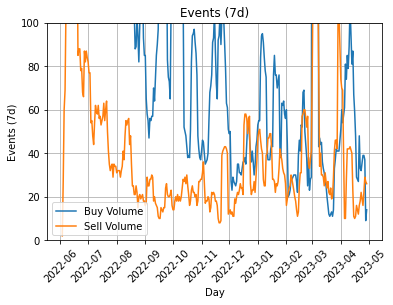

In [71]:
sns.lineplot(data=df, x='day', y='events_buy_rolling_7d')
sns.lineplot(data=df, x='day', y='events_sell_rolling_7d')
plt.title('Events (7d)')
plt.xlabel('Day')
plt.ylabel('Events (7d)')
plt.legend(['Buy Volume', 'Sell Volume'])
plt.xticks(rotation=45)  # rotate the x-axis tick labels by 45 degrees
plt.ylim([0,100])
plt.grid()
plt.show()

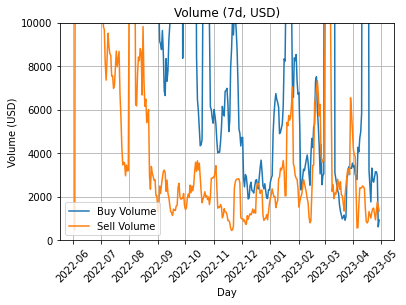

In [75]:
sns.lineplot(data=df, x='day', y='volume_usd_buy_rolling_7d')
sns.lineplot(data=df, x='day', y='volume_usd_sell_rolling_7d')

plt.title('Volume (7d, USD)')
plt.xlabel('Day')
plt.ylabel('Volume (USD)')
plt.legend(['Buy Volume', 'Sell Volume'])
plt.xticks(rotation=45)  # rotate the x-axis tick labels by 45 degrees
plt.ylim([0,10000])
plt.grid()
plt.show()

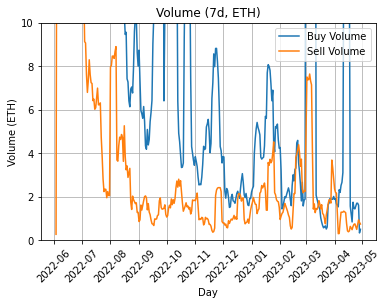

In [74]:
sns.lineplot(data=df, x='day', y='volume_eth_buy_rolling_7d')
sns.lineplot(data=df, x='day', y='volume_eth_sell_rolling_7d')

plt.title('Volume (7d, ETH)')
plt.xlabel('Day')
plt.ylabel('Volume (ETH)')
plt.legend(['Buy Volume', 'Sell Volume'])
plt.xticks(rotation=45)  # rotate the x-axis tick labels by 45 degrees
plt.ylim([0,10])
plt.grid()
plt.show()

## NFT Dimand Hander Plot from Flipside

In [217]:
query_string = f"""
WITH
last_sale_dt AS (
SELECT NFT_ADDRESS
      ,TOKENID
      ,MAX(BLOCK_TIMESTAMP) AS last_sale
FROM ethereum.core.ez_nft_sales
WHERE NFT_ADDRESS IN ('{address_wagdie_nft.lower()}'
                     ,'0x5af0d9827e0c53e4799bb226655a1de152a425a5' -- milady
                     ,'0x22d4c35a4f2b229a928b1b569b2f60225976426a' -- froyok
                     ,'0xed5af388653567af2f388e6224dc7c4b3241c544' -- azuki
                     )
GROUP BY 1,2
ORDER BY 2 DESC
)

SELECT *
      ,ROW_NUMBER()OVER(PARTITION BY NFT_ADDRESS ORDER BY last_sale DESC) AS n
FROM last_sale_dt
"""

In [218]:
df=querying_pagination(query_string)

running page 1
running page 2


In [219]:
df['last_sale']=pd.to_datetime(df['last_sale'])
df['n_normalized'] = df.groupby("nft_address")["n"].apply(lambda x: x / x.max())


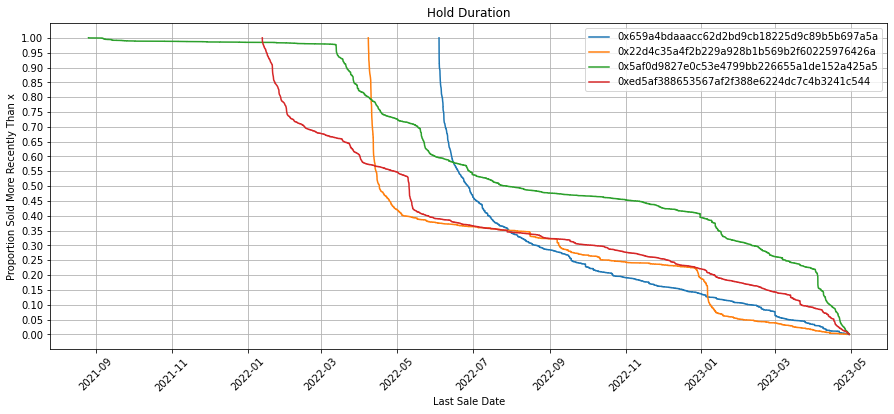

In [220]:
# sns.lineplot(x=df['last_sale'], y=df['n'], drawstyle='steps-post')
plt.figure(figsize=(15, 6))

for a in df.nft_address.unique():
    idx = df['nft_address']==a
    plt.plot(df.loc[idx]['last_sale'], df.loc[idx]['n_normalized'], drawstyle='steps-post'
             ,label=a)

plt.title('Hold Duration')
plt.xlabel('Last Sale Date')
plt.ylabel('Proportion Sold More Recently Than x')
plt.xticks(rotation=45)  # rotate the x-axis tick labels by 45 degrees
plt.grid()
# plt.grid(linewidth=0.5, alpha=0.5, axis='y', color='gray', linestyle='--')
plt.yticks(np.arange(0, 1.05, 0.05))
plt.legend()
plt.show()

## NFT Hold Length and Number of Sales When Sold

In [221]:
query_string = f"""WITH
last_sale_dts AS (
SELECT NFT_ADDRESS
      ,TOKENID
      ,BLOCK_TIMESTAMP
      ,LAG(BLOCK_TIMESTAMP,1)OVER(PARTITION BY NFT_ADDRESS,TOKENID ORDER BY BLOCK_TIMESTAMP ASC) AS last_timestamp
      ,RANK()OVER(PARTITION BY NFT_ADDRESS,TOKENID ORDER BY BLOCK_TIMESTAMP DESC) AS sales_ago
      ,RANK()OVER(PARTITION BY NFT_ADDRESS,TOKENID ORDER BY BLOCK_TIMESTAMP ASC) AS total_sales
FROM ethereum.core.ez_nft_sales
WHERE NFT_ADDRESS IN ('{address_wagdie_nft.lower()}'
                     )
)

SELECT *
      ,DATE_TRUNC('day',BLOCK_TIMESTAMP) AS day
      ,DATEDIFF('day',last_timestamp,BLOCK_TIMESTAMP) AS days_held
FROM last_sale_dts
"""

In [222]:
df=querying_pagination(query_string)

running page 1
running page 2


In [224]:
df['block_timestamp']=pd.to_datetime(df['block_timestamp'])
df['last_timestamp']=pd.to_datetime(df['last_timestamp'])
df['day']=pd.to_datetime(df['day'])

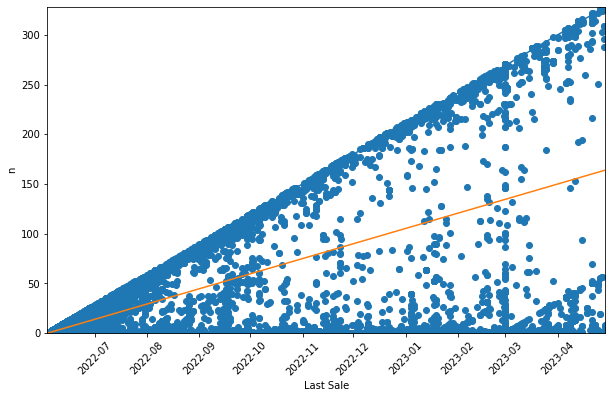

In [225]:
# also check distribution of days until sale by buy week;
# is this more even for NFTs bought in very first week? --> slow rug?

fig, ax = plt.subplots(figsize=(10, 6))

# Create a scatter plot of n by last_sale
plt.scatter(df['day'], df['days_held'])

ax.plot([0, 1], [0, 1], transform=ax.transAxes)
ax.plot([0, 1], [0, .5], transform=ax.transAxes)

# Set the labels for the x-axis and y-axis
plt.xlabel('Last Sale')
plt.xlim([df['day'].min(),df['day'].max()])
plt.ylim([df['days_held'].min(),df['days_held'].max()])
plt.ylabel('n')
plt.xticks(rotation=45)  # rotate the x-axis tick labels by 45 degrees

# Show the plot
plt.show()

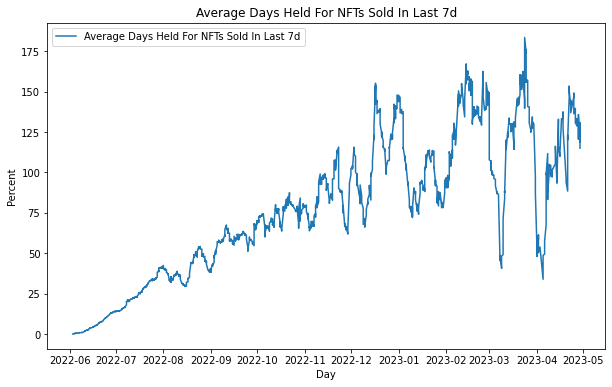

In [268]:
# Percent above/below rolling 7d average age
df=df.set_index('day').sort_index()
rolling_avg = df['days_held'].rolling('7d').mean()
# df['days_held_above_rolling_avg'] = (df['days_held'] > rolling_avg).astype(int)
# df_agg = df.groupby('day')['days_held_above_rolling_avg'].mean() * 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.index, rolling_avg, label='Average Days Held For NFTs Sold In Last 7d')

plt.title('Average Days Held For NFTs Sold In Last 7d')
ax.set_xlabel('Day')
ax.set_ylabel('Percent')
ax.legend()
plt.show()

df.reset_index(inplace=True)

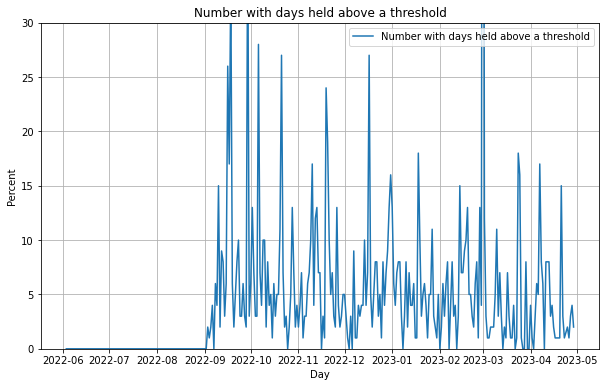

In [269]:
# Get number of sales that are above/below daily average age

#  ... base on the chart below...
# % of sales that are above/below daily average age
df['day_avg_days_held'] = df.groupby('day')['days_held'].transform('mean')

# df['days_held_above_avg'] = (df['days_held'] > df['day_avg_days_held']).astype(int)
# df_agg = df.groupby('day')['days_held_above_avg'].sum() #* 100

df['days_held_above_90'] = (df['days_held'] > 90).astype(int)
df_agg = df.groupby('day')['days_held_above_90'].sum() #* 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_agg.index, df_agg.values, label='Number with days held above a threshold')

plt.title("Number with days held above a threshold")
ax.set_xlabel('Day')
ax.set_ylabel('Percent')
ax.legend()
plt.ylim([0,30])
plt.grid()
plt.show()



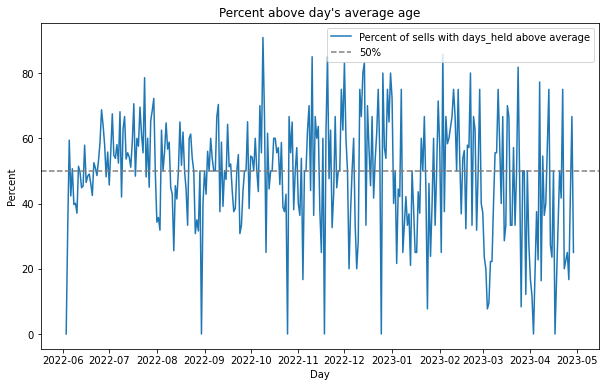

In [226]:
# % of sales that are above/below daily average age
df['day_avg_days_held'] = df.groupby('day')['days_held'].transform('mean')
df['days_held_above_avg'] = (df['days_held'] > df['day_avg_days_held']).astype(int)
df_agg = df.groupby('day')['days_held_above_avg'].mean() * 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_agg.index, df_agg.values, label='Percent of sells with days_held above average')
ax.axhline(y=50, ls='--', color='gray', label='50%')

plt.title("Percent above day's average age")
ax.set_xlabel('Day')
ax.set_ylabel('Percent')
ax.legend()
plt.show()


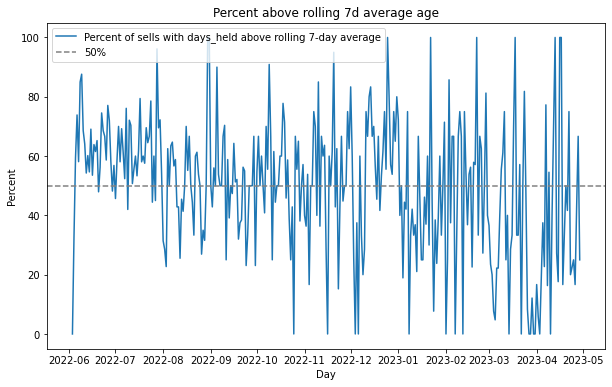

In [247]:
# Percent above/below rolling 7d average age
df=df.set_index('day').sort_index()
rolling_avg = df['days_held'].rolling('7d').mean()
df['days_held_above_rolling_avg'] = (df['days_held'] > rolling_avg).astype(int)
df_agg = df.groupby('day')['days_held_above_rolling_avg'].mean() * 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_agg.index, df_agg.values, label='Percent of sells with days_held above rolling 7-day average')
ax.axhline(y=50, ls='--', color='gray', label='50%')

plt.title('Percent above rolling 7d average age')
ax.set_xlabel('Day')
ax.set_ylabel('Percent')
ax.legend()
plt.show()

df.reset_index(inplace=True)


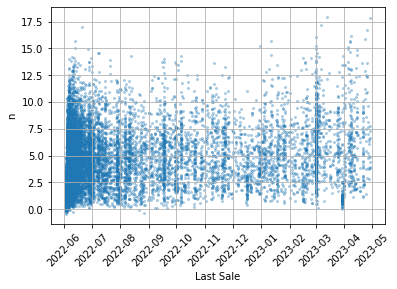

In [258]:
# Create a scatter plot of n by last_sale
jitter = np.random.normal(0, 0.4, size=(len(df),))
plt.scatter(df['day'], df['total_sales'] + jitter, s=4, alpha=0.3)

# Set the labels for the x-axis and y-axis
plt.xlabel('Last Sale')
plt.ylabel('n')
plt.xticks(rotation=45)  # rotate the x-axis tick labels by 45 degrees
plt.grid()
# Show the plot
plt.show()

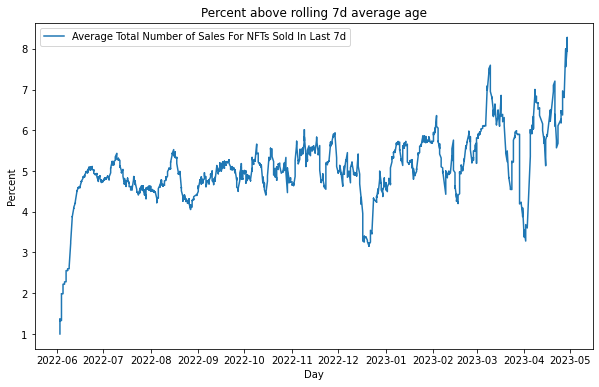

In [267]:
# Percent above/below rolling 7d average age
df=df.set_index('day').sort_index()
rolling_avg = df['total_sales'].rolling('7d').mean()
# df['days_held_above_rolling_avg'] = (df['days_held'] > rolling_avg).astype(int)
# df_agg = df.groupby('day')['days_held_above_rolling_avg'].mean() * 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.index, rolling_avg, label='Average Total Number of Sales For NFTs Sold In Last 7d')

plt.title('Percent above rolling 7d average age')
ax.set_xlabel('Day')
ax.set_ylabel('Percent')
ax.legend()
plt.show()

df.reset_index(inplace=True)

In [195]:
# Total profits to creators

# tmp=querying_pagination("""
# SELECT DATE_TRUNC('month',BLOCK_TIMESTAMP) AS date
#        ,SUM(CREATOR_FEE_USD) AS total_revenue
# FROM ethereum.core.ez_nft_sales
# WHERE NFT_ADDRESS ='0x659a4bdaaacc62d2bd9cb18225d9c89b5b697a5a'
# GROUP BY 1
# """)

# # tmp.total_revenue.sum() # 1.4M

running page 1
running page 2


## Swaps from uniswap pair contract

In [ ]:
# w3.eth.blockNumber
# events = contract_eth_ded.events.Swap.getLogs(fromBlock=0, toBlock='latest')
# events[0] # wont work -- same sender/to as in the subgraph...
# # events[0]
# contract_eth_ded.events.Swap().processLog(events[0])
# # Decode Swap events
# swaps = []
# for event in events:
#     decoded_event = contract_eth_ded.events.Swap().processLog(event)
#     swap = {
#         'sender': decoded_event[0]['args']['sender'],
#         'amount0In': decoded_event[0]['args']['amount0In'],
#         'amount1In': decoded_event[0]['args']['amount1In'],
#         'amount0Out': decoded_event[0]['args']['amount0Out'],
#         'amount1Out': decoded_event[0]['args']['amount1Out'],
#         'to': decoded_event[0]['args']['to'],
#         'timestamp': w3.eth.getBlock(decoded_event[0]['blockNumber'])['timestamp']
#     }
#     swaps.append(swap)

In [ ]:
# # contract_eth_ded
# # get the transaction receipt using the transaction hash
# tx_hash = '0x642416365e3e657caf9923f67ddc34d9444f37a6c4e9ba02f341dbb5806a7de4'
# # 0x642416365e3e657caf9923f67ddc34d9444f37a6c4e9ba02f341dbb5806a7de4
# tx_receipt = w3.eth.getTransactionReceipt(tx_hash)
# tx_receipt['from']
# # decode the transaction data using the ABI
# # function_name, args = w3.codec.decode_abi(tx_receipt['input'], abi_pair_eth_ded)


In [ ]:
# tx_receipt['from']

In [ ]:

# # Define Uniswap pair contract address
# pair_address = Web3.toChecksumAddress('0x4e4cc558ff956c7f500c4ada573fa97e63281153') # DED/ETH

# # Define topic hashes for events
# topic_hash = Web3.keccak(text='Swap(address,uint256,uint256,uint256,address,uint256)').hex()

# # Define block range for historical data
# block_start = int(17128403-2000)
# block_end = 17128403

# # Define parameters for eth_getLogs
# params = {
#     'fromBlock': Web3.toHex(block_start),
#     'toBlock': Web3.toHex(block_end),
#     'address': pair_address,
#     'topics': [topic_hash]
# }

# # Make RPC request to get logs
# response = requests.post(alchemy_url, data=json.dumps({
#     "jsonrpc": "2.0",
#     "method": "eth_getLogs",
#     "params": [params],
#     "id": 1
# }), headers={
#     "Content-Type": "application/json"
# })

# # Parse response to get transactions
# logs = response.json()['result']
# for log in logs:
#     print(f'Transaction Hash: {log["transactionHash"]}')
#     print(f'From Address: {log["topics"][1]}')
#     print(f'To Address: {log["topics"][2]}')
#     print(f'Amount In: {int(log["topics"][3], 16)}')
#     print(f'Amount Out: {int(log["data"][-64:], 16)}')
#     print('---')


In [ ]:
# response.json()

{'jsonrpc': '2.0', 'id': 1, 'result': []}

## Get and process ERC20 data

In [29]:
# get transfers 
start_block = date2block('2023-04-10')
df_transfers=get_transfers(contract_ded_token,start_block)

# convert for token decimals
df_transfers['value_adj']=df_transfers['value'].astype(float)/10**18
# df_transfers.to_csv('ded_transfers.csv')

In [ ]:
# create separate DataFrames for 'from' and 'to' addresses
df_to = df_transfers[['to', 'value_adj', 'blockNumber']].rename(columns={'to':'account'})
df_from = df_transfers[['from', 'value_adj', 'blockNumber']].rename(columns={'from':'account'})
df_from['value_adj'] = -df_from['value_adj']

# coombine to one df, and get totals for each account within blocks
df_concat = pd.concat([df_from,df_to])
df_concat = df_concat.groupby(['account', 'blockNumber'])['value_adj'].sum().reset_index().sort_values('blockNumber')
df_concat['cumulative'] = df_concat.groupby(['account', 'blockNumber'])['value_adj'].sum().groupby('account').cumsum().reset_index()['value_adj']

In [359]:
# TODO: plot value_adj over time after the uniswap pool is funded? 
# or plot the pool cumulative inflow/outflow over time?


In [358]:
# check a specific wallet
# note, sandwhich bots will have 0 since they trade the same quantities within blocks
# 0xcdfc8F3377bBf5c912D2b031b1691D91Fec9fF32 # me
df_concat.loc[df_concat['account']=='0xcdfc8F3377bBf5c912D2b031b1691D91Fec9fF32']

11659    1.688428e+09
11660    0.000000e+00
11661    5.339034e+08
11662    1.042386e+09
11663    1.668492e+09
11664    2.008447e+09
11665    2.629247e+09
11666    3.157817e+09
11667    4.064722e+09
11668    4.725722e+09
11669    5.214942e+09
11670    5.706956e+09
11671    6.205722e+09
11672    7.449691e+09
11673    4.000000e+09
11674    0.000000e+00
11675    1.636327e+09
11676    4.409227e+08
11677    6.092272e+07
11678    4.703699e+08
11679    5.960464e-08
11680    4.820451e+08
11681    5.960464e-08
11682    3.041728e+08
11683    5.960464e-08
11684    5.592933e+08
11685    8.057096e+08
11686    1.104992e+09
11687    1.342020e+09
11688    0.000000e+00
11689    2.946059e+08
11690    5.874167e+08
11691    2.010976e+09
11692    2.742101e+09
11693    2.012101e+09
11694   -2.384186e-07
11695    4.864619e+08
Name: cumulative, dtype: float64

In [ ]:
# accounts that sent more than they received?
# (shouldn't this only be the null address??)
# all are e-7 -- so approximately 0
(df_concat.loc[df_concat['value_adj']<0].groupby('account')['value_adj'].min().reset_index().sort_values('value_adj'))

In [310]:
df_concat.dtypes

account         object
value_adj      float64
blockNumber      int64
dtype: object

## Get and process NFT data

In [18]:
# get sales
tmp = getNftSales(address_wagdie_nft)
df_sales = pd.json_normalize(tmp, sep='_')

2000 MTQ4OTk1NjIsOTIsMA
3000 MTQ4OTk2NjUsMzY5LDA
4000 MTQ4OTk4MTcsMiww
5000 MTQ4OTk5NjUsMTYwLDA
6000 MTQ5MDAwODEsMTIwLDA
7000 MTQ5MDAzMjMsNDEsMA
8000 MTQ5MDEwNTMsMTAwLDA
9000 MTQ5MDMwODAsNDQyLDA
10000 MTQ5MDQxMzAsMTQ4LDA
11000 MTQ5MDQ4MzMsNDYsMA
12000 MTQ5MDYxNjgsNDg3LDA
13000 MTQ5MDkzOTcsMzYxLDA
14000 MTQ5MTA5NTcsMTUwLDA
15000 MTQ5MTgxMzEsMTAwLDA
16000 MTQ5MTg3MzMsMTMxNSww
17000 MTQ5MjI1MDUsMzUyLDA
18000 MTQ5Mjk2NzIsNDUsMA
19000 MTQ5NDAxNzIsNiww
20000 MTQ5NDkzNzYsMTMsMA
21000 MTQ5NjgwMDUsNDUsMA
22000 MTUwMjEyMzAsMjAzLDA
23000 MTUxMDQzOTgsMjMxLDA
24000 MTUzMDI5NjcsMjY2LDA
25000 MTU3ODk4NTgsMTUxLDA
26000 MTY0NTUwNjksMjQyLDA
26393 MTY5MDkwMjQsMTAyOSww
no more page keys


In [20]:
# sort by block
df_sales=df_sales.sort_values('blockNumber',ascending=True)

# convert float and int columns
def convert_to_float(col):
    if ('amount' in col.name)or ('quantity' in col.name) or ('decimals' in col.name):
        return col.astype(float)
    elif ('tokenId' in col.name):
        return col.astype(int)
    return col

df_sales = df_sales.apply(convert_to_float)
# get decimal converted amounts
df_sales['sellerFee_amount_dec'] = df_sales['sellerFee_amount']/10**df_sales['sellerFee_decimals']
df_sales['protocolFee_amount_dec'] = df_sales['protocolFee_amount']/10**df_sales['protocolFee_decimals']
df_sales['royaltyFee_amount_dec'] = df_sales['royaltyFee_amount']/10**df_sales['royaltyFee_decimals']

In [21]:
# map blocks -> timestamps, fill missing timestamps with 0
df_sales = df_sales.merge(block_timestamps_df, on='blockNumber',how='right')
# df_transfers = df_transfers.merge(block_timestamps_df, on='blockNumber',how='right')

In [22]:
# drop rows before any relevant events occurred
df_sales = df_sales.loc[df_sales.dropna()['datetime'].min() <= df_sales['datetime'] ]


In [230]:
# some sales are in the same transaction as transfers
# sum(df_sales.transactionHash.isin(df_transfers.transactionHex)) # = ~4k

4024

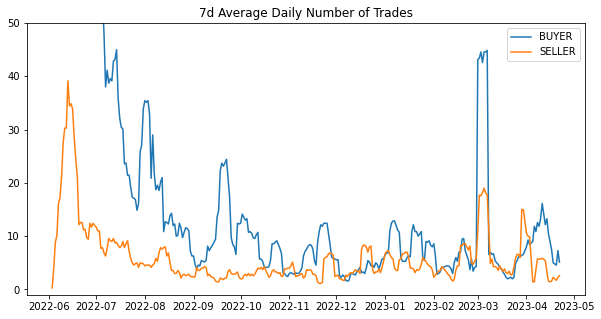

In [23]:

# group by taker and days from datetime column
df = df_sales.groupby(['taker', pd.Grouper(key='datetime', freq='D')])['transactionHash'].size()

# pivot the data and fill missing values with 0
# df = df.unstack(level=0).fillna(0)
df = df.reset_index()
df = df.pivot(index='datetime', columns='taker', values='transactionHash')
df = df.fillna(0)
df = df.reset_index()

# Calculate rolling 7-day sums for BUYER and SELLER
df = df.set_index('datetime')
df['BUYER_rolling'] = df['BUYER'].rolling('7D').sum()
df['SELLER_rolling'] = df['SELLER'].rolling('7D').sum()
df=df.reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
# Plot the rolling values
plt.plot(df['datetime'], df['BUYER_rolling']/7, label='BUYER')
plt.plot(df['datetime'], df['SELLER_rolling']/7, label='SELLER')
# plt.plot(df['datetime'], df['BUYER'], label='BUYER')
# plt.plot(df['datetime'], df['SELLER'], label='SELLER')
plt.title('7d Average Daily Number of Trades')
plt.ylim([-1,50])
plt.legend()

plt.show()



In [ ]:
# TODO: Net weekly flow;
# buyer spend - seller take

# TODO: Weekly,monthly median price (buy or sell)
# TODO: Median prices split by taker side



In [ ]:
# process into two dfs -- counts for buyers and sellers
# df=df_sales.groupby(['blockNumber','taker'])[['transactionHash']].count().sort_index().reset_index()
# df_buyer = df.loc[df['taker']=='BUYER'].set_index('blockNumber')
# df_seller = df.loc[df['taker']=='SELLER'].set_index('blockNumber')


# # get the latest block number
# latest_block_buyer = df_buyer.index.max()
# latest_block_seller = df_seller.index.max()

# # set the rolling window size based on the number of blocks in the range
# # needed since some blocks can be missing
# window_size_buyer = len(df_buyer.loc[latest_block-5760:latest_block, :].dropna())
# window_size_seller = len(df_seller.loc[latest_block-5760:latest_block, :].dropna())

# no! do by dates now, not blocks -- still fill mis
# join to all blocktimes to dates w no transactioons fill w 0
# agg by date


# TODO: add logic to fill missing blocks with 0 before the rolling sum
# currently -- blocks with 0 are dropped:
# rolling_count_buyer.index.max() - rolling_count_buyer.index.min(), len(rolling_count_buyer)
#  = (2200204, 11663)

# perform rolling operation on the value column
# rolling_count_buyer = df_buyer['transactionHash'].rolling(window_size_buyer).sum()
# rolling_count_seller = df_seller['transactionHash'].rolling(window_size_seller).sum()

# plot the rolling count
fig, ax = plt.subplots(figsize=(10, 5))
rolling_count_buyer.plot(label='buyer')
rolling_count_seller.plot(label='seller')
plt.title('~7d Rolling Number of NFT Transactions')
plt.legend()
plt.ylim([0,20])

In [ ]:
# create a sample dataframe with some missing block numbers
# data = {
#     'blockNumber': [1, 2, 4, 5, 7, 8],
#     'value': [10, 20, 30, 40, 50, 60]
# }
# df = pd.DataFrame(data)

# set blockNumber as index
# df = df.set_index('blockNumber')

# get the latest block number
latest_block = df.index.max()

# set the rolling window size based on the number of blocks in the range
window_size = len(df.loc[latest_block-6000:latest_block, :].dropna())

# perform rolling operation on the value column
rolling_count = df['value'].rolling(window_size).count()

# plot the rolling count
rolling_count.plot()


In [274]:
# blocks per day
24*60*60/15

5760.0

Text(0.5, 1.0, 'Transactions in Last Week')

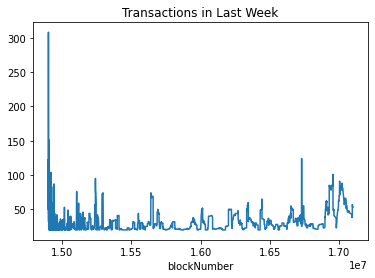

In [343]:

# TODO: 
# do this logic twice; once for each 'taker' value!!

df=df_sales.groupby(['blockNumber'])[['transactionHash']].count().sort_index()#.reset_index()
# get the latest block number
latest_block = df.index.max()

# set the rolling window size based on the number of blocks in the range
# needed since some blocks can be missing
window_size = len(df.loc[latest_block-5760*7:latest_block, :].dropna())

# perform rolling operation on the value column
rolling_count = df['transactionHash'].rolling(window_size).sum()

# plot the rolling count
rolling_count.plot()
plt.title('Transactions in Last Week')


(0.0, 20.0)

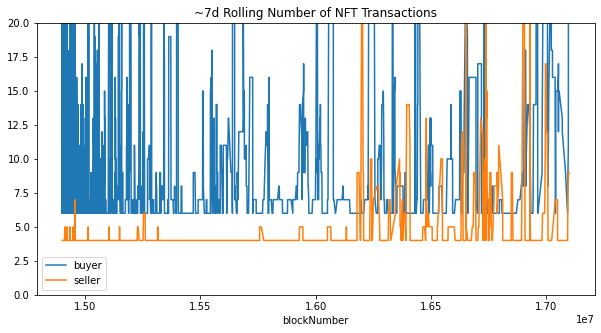

In [368]:
# process into two dfs -- counts for buyers and sellers
df=df_sales.groupby(['blockNumber','taker'])[['transactionHash']].count().sort_index().reset_index()
df_buyer = df.loc[df['taker']=='BUYER'].set_index('blockNumber')
df_seller = df.loc[df['taker']=='SELLER'].set_index('blockNumber')

# get the latest block number
latest_block_buyer = df_buyer.index.max()
latest_block_seller = df_seller.index.max()

# set the rolling window size based on the number of blocks in the range
# needed since some blocks can be missing
window_size_buyer = len(df_buyer.loc[latest_block-5760:latest_block, :].dropna())
window_size_seller = len(df_seller.loc[latest_block-5760:latest_block, :].dropna())

# TODO: add logic to fill missing blocks with 0 before the rolling sum
# currently -- blocks with 0 are dropped:
# rolling_count_buyer.index.max() - rolling_count_buyer.index.min(), len(rolling_count_buyer)
#  = (2200204, 11663)

# perform rolling operation on the value column
rolling_count_buyer = df_buyer['transactionHash'].rolling(window_size_buyer).sum()
rolling_count_seller = df_seller['transactionHash'].rolling(window_size_seller).sum()

# plot the rolling count
fig, ax = plt.subplots(figsize=(10, 5))
rolling_count_buyer.plot(label='buyer')
rolling_count_seller.plot(label='seller')
plt.title('~7d Rolling Number of NFT Transactions')
plt.legend()
plt.ylim([0,20])

In [ ]:
# process into two dfs -- counts for buyers and sellers
df=df_sales.groupby(['blockNumber','taker'])[['transactionHash']].count().sort_index().reset_index()
df_buyer = df.loc[df['taker']=='BUYER'].set_index('blockNumber')
df_seller = df.loc[df['taker']=='SELLER'].set_index('blockNumber')

# get the latest block number
latest_block_buyer = df_buyer.index.max()
latest_block_seller = df_seller.index.max()

# set the rolling window size based on the number of blocks in the range
# needed since some blocks can be missing
window_size_buyer = len(df_buyer.loc[latest_block-5760:latest_block, :].dropna())
window_size_seller = len(df_seller.loc[latest_block-5760:latest_block, :].dropna())

# TODO: add logic to fill missing blocks with 0 before the rolling sum
# currently -- blocks with 0 are dropped:
# rolling_count_buyer.index.max() - rolling_count_buyer.index.min(), len(rolling_count_buyer)
#  = (2200204, 11663)

# join to get all blocks, filled w 0

# roll sum over x blocks
# downsample x blocks?
# -- could also use integer division on blocks, group by?
# -- or better, block --> timestamp, then group by dates, then roll over dates.

# perform rolling operation on the value column
rolling_count_buyer = df_buyer['transactionHash'].rolling(window_size_buyer).sum()
rolling_count_seller = df_seller['transactionHash'].rolling(window_size_seller).sum()

In [ ]:

# plot the rolling count
fig, ax = plt.subplots(figsize=(10, 5))
rolling_count_buyer.plot(label='buyer')
rolling_count_seller.plot(label='seller')
plt.title('~7d Rolling Number of NFT Transactions')
plt.legend()
plt.ylim([0,20])

In [ ]:

# get the latest block number
latest_block = df.index.max()

# set the rolling window size based on the number of blocks in the range
# needed since some blocks can be missing
window_size = len(df.loc[latest_block-5760*7:latest_block, :].dropna())

# perform rolling operation on the value column
rolling_count = df['transactionHash'].rolling(window_size).sum()

# plot the rolling count
rolling_count.plot()
plt.title('Transactions in Last Week')



# # get the latest block number
# latest_block = df['blockNumber'].max()
# # set the rolling window size based on the number of blocks in the range
# # needed since some blocks can be missing
# window_size = len(df.loc[df['blockNumber'].between(latest_block-5760*7, latest_block), :].dropna())

# # Create a new DataFrame with a range of block numbers and both taker values
# # Get unique values of taker
# takers = df['taker'].unique()

# # Create separate arrays for each taker
# seller_blocks = np.tile(df.loc[df['taker'] == takers[0], 'blockNumber'].values, 2)
# buyer_blocks = np.tile(df.loc[df['taker'] == takers[1], 'blockNumber'].values, 2)

# # Concatenate the arrays into a single DataFrame
# block_range = pd.DataFrame({'blockNumber': np.concatenate([seller_blocks, buyer_blocks]),
#                             'taker': np.concatenate([np.full(len(seller_blocks), takers[0]),
#                                                      np.full(len(buyer_blocks), takers[1])])})


# # Join the new DataFrame with the original DataFrame
# df = pd.merge(block_range, df, how='left', on=['blockNumber', 'taker'])

# # Perform forward fill to fill the missing block numbers with the previous value
# df['transactionHash'].fillna(0, inplace=True)

# df['count'] = df.groupby('taker')['transactionHash'].rolling(window=6000).sum().reset_index(0, drop=True)


In [341]:
# rolling_count

KeyboardInterrupt: 

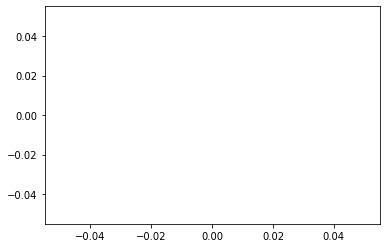

In [333]:

# Plot the rolling count
sns.lineplot(data=df, x='blockNumber', y='transactionHash', hue='taker')
plt.title('Transactions in Last 6000 Blocks')
plt.xlabel('Block Number')
plt.ylabel('Transaction Count')


In [ ]:

# Convert the index to a numeric data type
# df.index = pd.to_numeric(df.index)
df=df_sales.groupby(['blockNumber','taker'])[['transactionHash']].count().reset_index().set_index('blockNumber').sort_index()

# Create a new DataFrame with a range of block numbers
block_range = pd.DataFrame(index=range(df.index.min(), df.index.max()+1))

# Join the new DataFrame with the original DataFrame
df = df.join(block_range, how='outer')

# Perform forward fill to fill the missing block numbers with the previous value
# df.fillna(method='ffill', inplace=True)
df.fillna(0, inplace=True)

# # Reset the index and drop duplicates
# df.reset_index(inplace=True)
# df.drop_duplicates(subset='blockNumber', keep='last', inplace=True)
# df.set_index('blockNumber', inplace=True)

# Compute rolling count for each value of 'taker' over a window of 6000 blocks
# df['count'] = df.groupby('taker')['transactionHash'].rolling(window=6000).sum() #.reset_index(0, drop=True)

df.head()

<AxesSubplot:xlabel='blockNumber'>

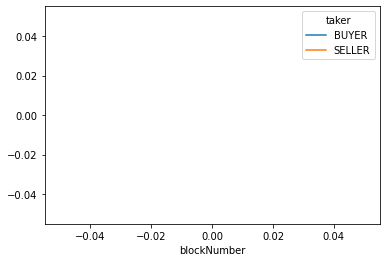

In [335]:
# df['count'] = 
df.groupby('taker')['transactionHash'].rolling(window=5760*7).sum().reset_index().rename(columns={'level_1':'blockNumber'}).dropna()
# .reset_index(0, drop=True)
# sns.lineplot(data=df.groupby('taker')['transactionHash'].rolling(window=5760*7).sum().reset_index().rename(columns={'level_1':'blockNumber'})
#             ,x='blockNumber'
#             ,y='transactionHash'
#             ,hue='taker' )


Text(0.5, 1.0, 'Seller Fee Amount vs. Block Number')

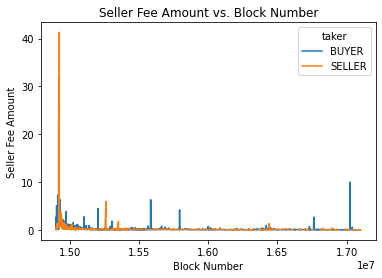

In [256]:
# average price per block

sns.lineplot(data=df_sales.groupby(['blockNumber','taker'])[['sellerFee_amount_dec']].mean().reset_index()
            ,x='blockNumber'
            ,y='sellerFee_amount_dec'
            ,hue='taker' )

# set the x-axis label
plt.xlabel('Block Number')

# set the y-axis label
plt.ylabel('Seller Fee Amount')

# set the plot title
plt.title('Seller Fee Amount vs. Block Number')

In [231]:
# df_transfers.head()

,from,to,tokenId,event,logIndex,transactionIndex,transactionHash,transactionHex,address,blockHash,blockHex,blockNumber
0,0xad1e365152589d3501340Af5c004bfa1EF0d724a,0x824Ae3Bfe2771151dB8c7b7Defb96a9F67695ade,5637,Transfer,83,45,b'\x10\xb4B\\\xeeE/U\x13\xc8\x00@\x8c\xd9\xa5~...,0x10b4425cee452f5513c800408cd9a57e50e95135cbe0...,0x659A4BdaAaCc62d2bd9Cb18225D9C89b5B697A5A,b'v\xf2\xe8\xa2\xdd\xf88\x178\xfe\xf1\xc7\xe3\...,0x76f2e8a2ddf8381738fef1c7e39eaec27219adc5f653...,15159451
1,0xA5D45dA8A2d08f91e6f63B7315f66B71B4A215f8,0x9EA6C60a81864D02ff87280315b1a3e71efCa204,1625,Transfer,481,343,b' D\xa2\xe8\x81R\xde\xe7\xf5\xc3\x92\x01\xc8\...,0x2044a2e88152dee7f5c39201c80de4aca718ec1c1308...,0x659A4BdaAaCc62d2bd9Cb18225D9C89b5B697A5A,b'}\xe3\xf6\xf6\x0f\xb97`\xb0X\x1bjH\xe2\x8c{\...,0x7de3f6f60fb93760b0581b6a48e28c7b0ae4501d0a4d...,15160857
2,0x59A3da7B35115770216B183e35eCE6dEe85459dc,0x9EA6C60a81864D02ff87280315b1a3e71efCa204,3374,Transfer,134,59,b'\xad\x7f\xbc\xc5*\xd6\xf1\xee\x81\xe4\xe0\xc...,0xad7fbcc52ad6f1ee81e4e0c72fa4881507d1c1a941d4...,0x659A4BdaAaCc62d2bd9Cb18225D9C89b5B697A5A,"b'[b\x9bX\x96\xf8\x8ftyw2\x06,\xeba\xf7SF\r\xd...",0x5b629b5896f88f74797732062ceb61f753460ddb480b...,15160862
3,0x0Dfe2548fd12BEd06b6797EF73f5C4fd3B695ecf,0xF36Fc687C16F3021635B848A7D7450f5217240DA,1763,Transfer,25,71,b'S\xee\xb9cm\x10\x0fQ\x99\x8d\x80\xa4\xf3v\x8...,0x53eeb9636d100f51998d80a4f37689b1d7fe95f4d0bb...,0x659A4BdaAaCc62d2bd9Cb18225D9C89b5B697A5A,b'\x90&?_\x96\xe4\xf4\xc6)\xb4\x86\x9d?\xabb\x...,0x90263f5f96e4f4c629b4869d3fab62d4ad713438aa7a...,15161048
4,0xCdd60e7B7ADe44053a67349A6E856c0aE33d2B91,0x8005488FF4f8982D2D8c1D602e6d747b1428dd41,1100,Transfer,46,83,b'\x81\x9a\xbepWL\xed\xaa\xba\xabBc\x1du\xc8\x...,0x819abe70574cedaabaab42631d75c8a9aeb5662d944d...,0x659A4BdaAaCc62d2bd9Cb18225D9C89b5B697A5A,b'C\xb9(T)\xaf\xfe\x1a\xa1\xe1\x82a\xae\x04\xc...,0x43b9285429affe1aa1e18261ae04c16c3e0ba3b8fbe2...,15161400


# Data retreival & local storage

# Transfer-propogated profits

- problem: users can have many addresses, and may transfer between their addresses before selling.
- this methodology mitigates this by attributing proceeds from a sale to all addresses that held since the last sale (will vastly overcount total proceeds but may better detect addresses of "insider accounts")

- Get all addresses before a sale and propogate the proceeds back to any holder between sales; 
- Reset the propogation after each sale of a wagdie -- can use window functions and partition by here.
